# Финальный проект: Прогнозирование оттока клиентов

## Неделя 3: Построение baseline-решений

** 2016/12/21**

*Юрий Исаков*

В рамках проекта мы будем решать задачу прогнозирования оттока пользователей, или churn prediction. Эта задача заключается в прогнозировании вероятности того, что клиент перестанет пользоваться сервисом в течение некоторого заданного заранее промежутка времени, например, решит перейти к конкуренту или откажется от использования услуги данного типа вообще.

Данные были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

---

В этом задании вам предстоит построить несколько моделей и оценить их качество. Эти модели будут служить нам в качестве baseline-решений и пригодятся сразу для нескольких задач:

1. Во-первых, на разработку baseline-модели не должно уходить много времени (это требование исходит из оценок затрат на проект в целом - большую часть времени все же нужно потратить на основное решение), процесс должен быть простым, на подавляющем большинстве этапов должны использоваться готовые протестированные инструменты. Все это приводит к тому, что baseline-модели - это дешевый способ сделать грубую оценку потенциально возможного качества модели, при построении которого вероятность допущения ошибок относительно невелика.

2. Во-вторых, использование моделей разного типа при построении baseline'ов, позволяет на раннем этапе сделать предположения о том, какие подходы являются наиболее перспективными и приоритизировать дальнейшие эксперименты.

3. Наличие baseline-моделей позволяет оценить, какой прирост качества дают различные преобразования, усложнения, оптимизации и прочие активности, которые вы предпринимаете для построения финального решения.

4. Наконец, если после построение сложного решения оценка его качества будет очень сильно отличаться от оценки качества baseline-моделей, то это будет хорошим поводом поискать в решении ошибки.

---

**Для этого проекта есть два датасета, их можно отличить если посмотреть первые несколько строчек исходных данных или посчитать долю положительного класса (0.074275 или 0.0744). В этом ноутбуке используется первая версия датасета, которую можно скачать с [гитхаба](https://github.com/yurkai/churn/tree/master/data).**

In [1]:
# библиотеки, настройки
import pandas as pd
import numpy as np
import itertools
import pickle

import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# коэффициент корреляции Крамера для категориальных переменных
# http://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# обертка для функции выше
def get_cramers_cor(var1, var2):
    if var1.equals(var2):
        return 1.0
    confusion_matrix = pd.crosstab(var1, var2)
    return cramers_corrected_stat(np.array(confusion_matrix))

## Задание

Обучите 3 разные baseline-модели на полученных наборах данных и оцените их качество. На прошлой неделе вы выбрали методику оценки качества моделей на основе кросс-валидации, а также основную и вспомогательные метрики. Оцените с их помощью получившуюся модель. Обратите внимание, что под разными моделями понимаются именно разные алгоритмы классификации. Например, 2 модели, реализующие метод k ближайших соседей с разными k, будут считаться одним baseline-решением (хотя и с разными параметрами). Напоминаем, что отложенная выборка (hold-out dataset) не должна использоваться для построения и оценки baseline-моделей!

Можно (но не обязательно) рассмотреть следующий набор алгоритмов:

* Линейная модель (например, реализация sklearn.linear_model.RidgeClassifier)

* Случайный лес (например, реализация sklearn.ensemble.RandomForestClassifier)

* Градиентный бустинг (например, реализация sklearn.ensemble.GradientBoostingClassifier)



В качестве решения приложите получившийся jupyther notebook. Убедитесь, что в нем присутствуют:

* все baseline-модели, которые вы построили;

* качество всех построенных моделей оценено с помощью кросс-валидации, и это понятно из текста в jupyther notebook;

* все модели оценены с помощью основной и дополнительных метрик качества.

### 1. Загрузка данных и выбор признаков

Загрузим данные только с теми признаками, которые мы отобрали на первой неделе.

In [3]:
# загрузка данных
data = pd.read_csv("data/orange_small_churn_data.train")
labels = pd.read_csv("data/orange_small_churn_labels.train", header=None)
labels.columns = ["label"]
# заменю -1 на нолики
labels.loc[labels.label == -1, 'label'] = 0


# загрузка словарика с категориальными переменными
with open('data/feat_cat_values_01.pickle', 'rb') as handle:
    values_feat_cat = pickle.load(handle)

    
# числовые признаки
feat_num = ['Var30', 'Var84', 'Var130', 'Var161', 'Var176', 'Var101']

Посмотрим, есть ли повторяющиеся признаки, посчитаем для них корреляции Крамера и построим график тепловую карту корреляций:

CPU times: user 2min 58s, sys: 59 s, total: 3min 57s
Wall time: 4min 3s


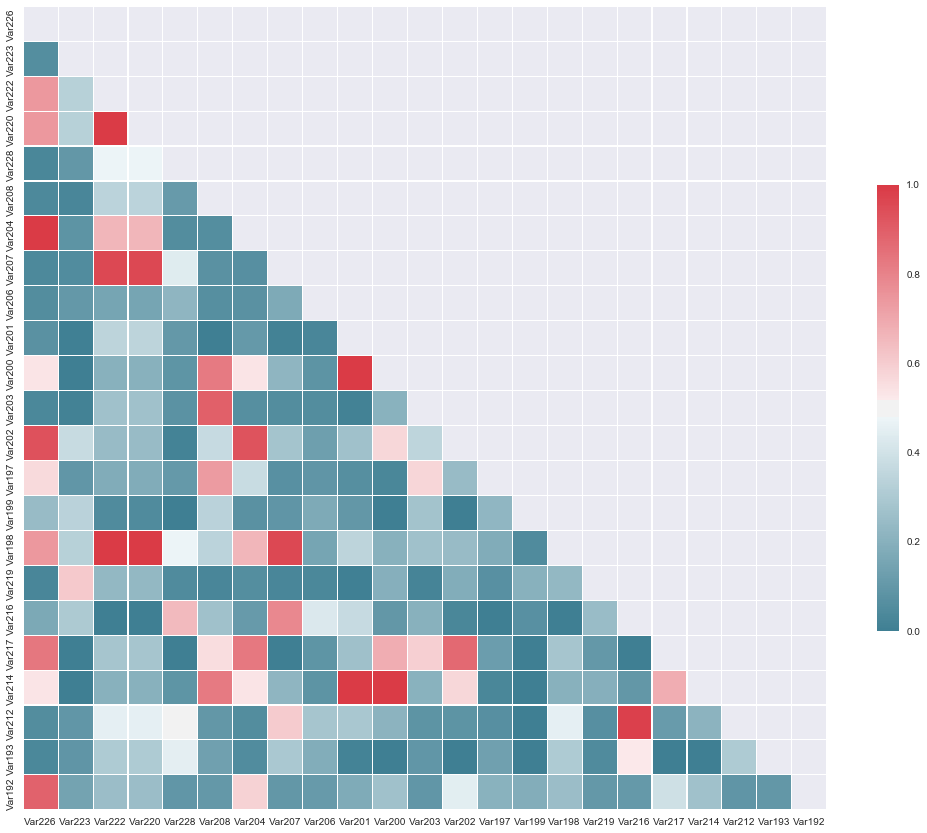

In [4]:
%%time
# считаем корреляции
conf_matrix_cor = pd.DataFrame(1.0, index=values_feat_cat.keys(), columns=values_feat_cat.keys())
for feat in itertools.combinations(values_feat_cat.keys(), 2):
    conf_matrix_cor.loc[feat[0], feat[1]] = get_cramers_cor(data[feat[0]], data[feat[1]])
    conf_matrix_cor.loc[feat[1], feat[0]] = conf_matrix_cor.loc[feat[0], feat[1]]

# маска треугольника
mask = np.zeros_like(conf_matrix_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# параметры графика
f, ax = plt.subplots(figsize=(18, 16))

# палитра
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# отрисовка тепловой карты
sns.heatmap(conf_matrix_cor, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)

Есть признаки, которые одинаковы с точностью до перестановок и просто очень сильно коррелирующие:

In [5]:
for feat in itertools.combinations(values_feat_cat.keys(), 2):
    if conf_matrix_cor.loc[feat[0], feat[1]] > 0.9:
        print feat, conf_matrix_cor.loc[feat[0], feat[1]]

('Var226', 'Var204') 1.0
('Var226', 'Var202') 0.933792355548
('Var222', 'Var220') 1.0
('Var222', 'Var207') 0.960768922831
('Var222', 'Var198') 1.0
('Var220', 'Var207') 0.960768922831
('Var220', 'Var198') 1.0
('Var204', 'Var202') 0.93103882438
('Var207', 'Var198') 0.960768922831
('Var201', 'Var200') 1.0
('Var201', 'Var214') 1.0
('Var200', 'Var214') 1.0
('Var216', 'Var212') 0.980580675691


Удалим эти признаки и оставим только нужные. В итоге останется 25 колонок:

In [6]:
# надо удалить признаки из рассмотрения (V Cramer = 1)
feat_cat_exclude = ['Var226', 'Var214', 'Var198', 'Var220'] 

# категориальные признаки
feat_cat = list(set(values_feat_cat.keys()) - set(feat_cat_exclude))
feat_use = feat_num + feat_cat

# оставляем только нужные признаки
data = data[feat_use]

data.head()

,Var30,Var84,Var130,Var161,Var176,Var101,Var192,Var223,Var222,Var193,...,Var208,Var219,Var216,Var204,Var207,Var206,Var201,Var200,Var203,Var202
0,NaN,NaN,NaN,NaN,NaN,NaN,kMJt0GoOh3,LM8l689qOp,9HlNxGX,RO12,...,kIsH,FzaX,mAjbk_S,C7DI,me75fM6ugJ,IYzP,NaN,NaN,9_Y1,EVXS
1,NaN,NaN,NaN,NaN,NaN,NaN,3HjOj17ejg,jySVZNlOJy,JaZwBif,RO12,...,kIsH,FzaX,mAjbk_S,iVbl,me75fM6ugJ,IYzP,NaN,NaN,9_Y1,7dqt
2,NaN,NaN,NaN,NaN,NaN,NaN,1YVgUHXZeb,LM8l689qOp,9JvQQMs,RO12,...,kIsH,FzaX,mAja5EA,LqKm,me75fM6ugJ,IYzP,NaN,3Vucl6U,9_Y1,TxB5
3,NaN,NaN,NaN,NaN,NaN,NaN,zKnr4RXktW,LM8l689qOp,xmA7A2G,RO12,...,kIsH,FzaX,XTbPUYD,Cgc3,me75fM6ugJ,haYg,NaN,jhomLZ5,9_Y1,3VzB
4,NaN,NaN,NaN,NaN,NaN,NaN,639TmBQxul,LM8l689qOp,PSKQZmh,RO12,...,kIsH,FzaX,kZJtVhC,TjV7,me75fM6ugJ,zm5i,NaN,NaN,9_Y1,2xl_


### 2. Преобразование признаков, кросс-валидация и отложенная выборка

Прежде чем отделить отложенную выборку и разбить данные для кросс-валидации переведем категориальные признаки в бинарные. Сначала необходимо составить словарь, по которому будут выполняться преобразования, т.к. нам нужные не все значения, а лишь те, которые мы отобрали на первой неделе (содержатся в словаре values_feat_cat):

In [7]:
%%time
#  оставляем только нужные значения у признаков по словарю feat_cat_use
# сделаем словарик для замены dict_replace
# все значения, которых нет в словаре values_feat_cat заменим на какое-то специальное значение
replace_value = 'trash'
dict_replace = dict()
for feat in feat_cat:
    values_to_replace = list(set(data[feat].unique()) - set(values_feat_cat[feat]))
    values_to_replace = [x for x in values_to_replace if x==x] # убираем nan
    # print feat, len(set(data[feat].unique())), len(values_feat_cat[feat]), len(values_to_replace)
    dict_replace[feat] = dict.fromkeys(values_to_replace, replace_value)

# замена значений в данных по словарику
data = data.replace(dict_replace)

CPU times: user 2min 34s, sys: 1.44 s, total: 2min 35s
Wall time: 2min 35s


In [9]:
# заменим категораиальные признаки бинарными и заново соберем датасет
data_num = data[feat_num].fillna(data[feat_num].mean())
data_cat = pd.get_dummies(data[feat_cat], dummy_na=True)
data = pd.concat([data_num, data_cat], axis = 1)

data.shape

(40000, 3205)

In [10]:
# отделим отложенную выборку
X, X_hold_out, y, y_hold_out = train_test_split(data, labels.label, test_size=0.1, random_state=19, stratify = labels)

# разобьем рабочие данные для кросс-валидации, поделим на 9 подвыборок
skf = StratifiedKFold(n_splits=9, random_state=19)

### 3. Построение бейслайн моделей

Построим модели с параметрами по умолчанию (ну почти) и посчитаем их метрики на кросс-валидации. В качестве основной будем использовать ROC-AUC. Также важными оценками моделей будут Precission и Recall. Также выведем PR-AUC, чтобы два раза не вставать.

Использовать будем следующие модели: логистическая регрессия (LogisticRegression), случайный лес (RandomForestClassifier), градиентный бустинг (GradientBoostingClassifier).

In [11]:
# печатаем метрики по кросс-валидации
def get_cv_roc_pr_rc(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        y_pred = clf.predict(X.iloc[test,:])
        y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(metrics.roc_auc_score(y.iloc[test], y_pred_prob))
        pr_auc.append(metrics.average_precision_score(y.iloc[test], y_pred_prob))
        precision.append(metrics.precision_score(y.iloc[test], y_pred))
        recall.append(metrics.recall_score(y.iloc[test], y_pred))

    print 'ROC-AUC:', np.mean(roc_auc)
    print 'PR-AUC:', np.mean(pr_auc)
    print 'Precission:', np.mean(precision)
    print 'Recall:', np.mean(recall)
    
    return roc_auc, pr_auc, precision, recall, models

In [12]:
%%time

# Логистическая регрессия
clf = LogisticRegression(n_jobs=-1)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, y)

ROC-AUC: 0.87837015314
PR-AUC: 0.598585653518
Precission: 0.76121438909
Recall: 0.364992203918
CPU times: user 33 s, sys: 6.91 s, total: 40 s
Wall time: 40 s


In [13]:
%%time

# Случайный лес
clf = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, y)

ROC-AUC: 0.853356609908
PR-AUC: 0.488953850587
Precission: 0.647428143329
Recall: 0.378835584279
CPU times: user 14min 26s, sys: 13.5 s, total: 14min 39s
Wall time: 4min 39s


In [130]:
%%time

# Градиентный бустинг
clf = GradientBoostingClassifier(n_estimators = 30, random_state = 19)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, y)

ROC-AUC: 0.872244131147
PR-AUC: 0.595434073613
Precission: 0.812284019125
Recall: 0.295797899452
CPU times: user 7min 13s, sys: 15.4 s, total: 7min 28s
Wall time: 7min 38s


Были обучены три модели: логистическая регрессия, случайный лес и градиентный бустинг. Все три модели показали примерно одинаковое качество, за отправные значения примем метрики, показанные логистической регрессией, она считалась быстрее всего:

* ROC-AUC:  0.87

* Precission:  0.76

* Recall:  0.36